<span style="font-weight:bold; font-size: 3rem; color:#0047AB;">Model Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Prepare feature view by combining selected columns from feature groups
2. Process data for training
3. Train model
4. Evaluating the model (Feature importance, avoding overfitting...)
5. Saving and uploading model to Hopsworks


## <span style='color:#ff5f27'> Imports</span>

In [59]:
import pandas as pd
import os
import numpy as np
import requests
import datetime
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import datetime
import time
import json
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import MultipleLocator
import openmeteo_requests
import requests_cache
from retry_requests import retry
import hsfs
from pathlib import Path
from dotenv import load_dotenv
import hopsworks
import sys

root_dir = Path().resolve().parent
sys.path.append(str(root_dir))

from format_data import format_weather_data, format_price_data, merge_data
from get_electricity_prices import get_data
from get_weather_data import get_historical_weather, get_weather_forecast

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from format_data import format_weather_data, format_price_data, process_weather_data
from get_electricity_prices import get_data
from get_weather_data import get_historical_weather, get_weather_forecast
from entsoe_data import fetch_historical_data, ensure_valid_series

### Connect to Hopsworks and retrieve feature store

In [60]:
load_dotenv()
hopsworks_api = os.getenv("HOPSWORKS_API_KEY")

os.environ["HOPSWORKS_API_KEY"] = hopsworks_api

project = hopsworks.login()

print(f"Connected to project: {project.name}")

2025-01-07 12:27:08,135 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-01-07 12:27:08,163 INFO: Initializing external client
2025-01-07 12:27:08,164 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-07 12:27:09,470 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1169556
Connected to project: sthaji


In [61]:
fs = project.get_feature_store()

In [62]:
weather_fg = fs.get_feature_group(
    name='weather_data_3',
    version=1,
)

entsoe_fg = fs.get_feature_group(
    name='entsoe_data_3',
    version=1,
)

## <span style='color:#ff5f27'> Prepare feature view by combining selected columns from feature groups</span>

### Feature selection

Here different columns have been tested to make sure model is not overfitting

In [108]:
entsoe_columns = [
     'prices', 'imported_energy', 'total_load', 'total_generation_se',
     'prices_lag', 'imported_energy_lag', 'total_load_lag', 'future_price'
 ]

weather_columns = [
    'date', 'temperature_2m', 'wind_speed_100m']
    #'temperature_2m_lag', 'wind_speed_100m_lag']

selected_features = entsoe_fg.select(entsoe_columns).join(weather_fg.select(weather_columns), on=['date'], join_type='inner')
#selected_features = entsoe_query.join(weather_query, on=['date'])



# Show the first 10 rows of the feature view to verify
selected_features.show(10)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.81s) 


,prices,imported_energy,total_load,total_generation_se,prices_lag,imported_energy_lag,total_load_lag,future_price,date,temperature_2m,wind_speed_100m
0,37.00,-2125.0,20363.0,3313.0,55.26,-2133.0,20351.0,38.76,2022-11-01 03:00:00+00:00,8.565000,17.283749
1,77.99,-1354.0,25407.0,3946.0,59.95,-1533.0,23883.0,84.40,2022-11-01 07:00:00+00:00,8.264999,16.516901
2,91.30,-1995.0,26023.0,3295.0,72.17,-1895.0,25661.0,97.84,2022-11-02 15:00:00+00:00,9.365000,22.682856
3,40.21,-1993.0,20767.0,3413.0,38.95,-2084.0,20719.0,42.47,2022-11-03 03:00:00+00:00,6.115000,21.933426
4,76.00,-2009.0,24412.0,3956.0,50.00,-2199.0,22447.0,87.20,2022-11-03 06:00:00+00:00,7.465000,15.021105
5,100.02,-2688.0,25923.0,2546.0,68.35,-2452.0,24461.0,103.30,2022-11-04 07:00:00+00:00,8.115000,29.142216
6,240.55,-2254.0,26481.0,4567.0,122.21,-2013.0,26961.0,213.76,2022-11-04 18:00:00+00:00,8.065000,32.839027
7,129.04,-2620.0,21896.0,2320.0,53.02,-2707.0,21278.0,139.39,2022-11-05 07:00:00+00:00,8.415000,29.964457
8,114.45,-2005.0,24069.0,2731.0,133.83,-2155.0,23740.0,96.36,2022-11-05 11:00:00+00:00,7.365000,29.379175
9,88.72,-2291.0,23828.0,2436.0,96.36,-1977.0,23999.0,109.63,2022-11-05 13:00:00+00:00,7.415000,28.555965


### Creating feature view

In [109]:
feature_view = fs.get_or_create_feature_view(
    name='electricity_price_fv_3',
    description="weather + entose features with electricity prices as the target",
    version=1,
    labels=['future_price'],
    query=selected_features,
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1169556/fs/1160259/fv/electricity_price_fv_3/version/1


## <span style='color:#ff5f27'> Process data for training</span>

In [135]:
from random import seed


X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_size = 0.2, seed=42
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.62s) 
2025-01-07 13:02:22,468 WARNING: VersionWarning: Incremented version to `2`.

2025-01-07 13:02:22,469 INFO: Provenance cached data - overwriting last accessed/created training dataset from 1 to 2.


### If contains fresh data, need to remove NaN values (y-label is NaN)

In [136]:
# Get the maximum dates in X_train and X_test
max_date_train = X_train['date'].max()
max_date_test = X_test['date'].max()

# Check which dataset contains the maximum date
if max_date_train > max_date_test:
    max_id = X_train['date'].idxmax()
    X_train = X_train.drop(max_id)
else:
    max_id = X_test['date'].idxmax()
    X_test = X_test.drop(max_id)

training_features = X_train.drop(columns=['date'])
test_features = X_test.drop(columns=['date'])

y_train = y_train.dropna()
y_test = y_test.dropna()

In [137]:
#  check length of all dataframes
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

print(len(training_features))
print(len(test_features))

print(training_features.columns)

14804
3702
14804
3702
14804
3702
Index(['prices', 'imported_energy', 'total_load', 'total_generation_se',
       'prices_lag', 'imported_energy_lag', 'total_load_lag', 'temperature_2m',
       'wind_speed_100m'],
      dtype='object')


In [138]:
os.makedirs('model', exist_ok=True)

## <span style='color:#ff5f27'> Train XGB Regressor model</span>

In this section also comparing MSE for both training and test sets. 

In [139]:
from sklearn.metrics import mean_squared_error, r2_score

# Train the model
xgb_regressor = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,  
    learning_rate=0.1,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=1.0,
    reg_alpha = 30.0,  # L1 regularization
    # reg_lambda = 3.0  # L2 regularization
)
xgb_regressor.fit(training_features, y_train)

# Predictions on training and test sets
y_train_pred = xgb_regressor.predict(training_features)
y_test_pred = xgb_regressor.predict(test_features)

# Calculate MSE and R² for training set
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate MSE and R² for test set
test_mse = mean_squared_error(y_test.iloc[:, 0], y_test_pred)
test_r2 = r2_score(y_test.iloc[:, 0], y_test_pred)

# Print results
print("Training Set Results:")
print(f"  MSE: {train_mse:.4f}")
print(f"  R²: {train_r2:.4f}")

print("\nTest Set Results:")
print(f"  MSE: {test_mse:.4f}")
print(f"  R²: {test_r2:.4f}")

# # print accuracy
# accuracy = xgb_regressor.score(test_features, y_test)
# print(f"Accuracy: {accuracy * 100.0:.2f}%")



Training Set Results:
  MSE: 58.3663
  R²: 0.9883

Test Set Results:
  MSE: 309.1486
  R²: 0.9364
Accuracy: 93.64%


### Apart from a complete grid search, also regularly checking best param for L1 Regularization

In [ ]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'reg_alpha': [0.1, 1.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
# }

# grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(training_features, y_train)

# print("Best reg_alpha:", grid_search.best_params_['reg_alpha'])
# # print all best params
# print(grid_search.best_params_)

Best reg_alpha: 30.0
{'reg_alpha': 30.0}


In [83]:
# correlation matrix
#import seaborn as sns
# import matplotlib.pyplot as plt
# plt.figure(figsize=(20,20))
# cor = X_train.corr()
# sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
# plt.show()


## <span style='color:#ff5f27'> Evaluate model</span>

In [133]:
df = y_test
df['predicted_price'] = y_test_pred

inf


Printing to get overview of accuracy of model

In [125]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.tail(5)

,future_price,predicted_price,date
18503,0.52,9.009863,2024-12-31 22:00:00+00:00
10554,2.16,0.615668,2024-12-31 23:00:00+00:00
11676,10.00,10.776968,2025-01-06 03:00:00+00:00
17337,23.82,21.540764,2025-01-06 05:00:00+00:00
9341,26.87,26.760324,2025-01-06 15:00:00+00:00


### Feature importance analysis to avoid overfitting and simplify model

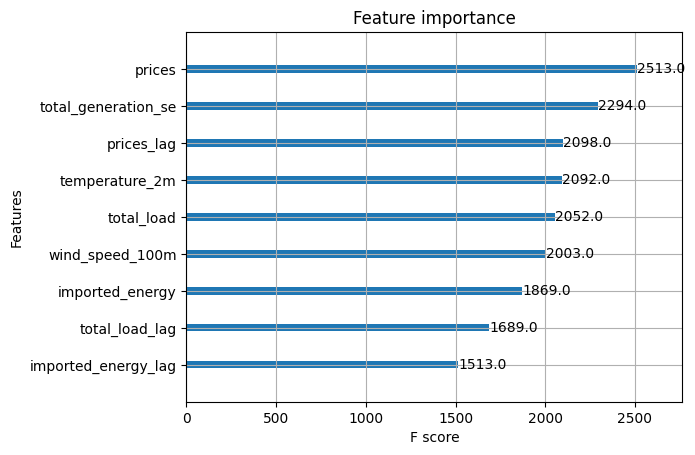

In [127]:

from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(xgb_regressor)
pyplot.show()


## <span style='color:#ff5f27'> Save and upload model to Hopsworks</span>

In [128]:
model_dir = "SE3_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

In [129]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(training_features)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [130]:
xgb_regressor.save_model(model_dir + "/model_se3.json")

In [131]:
res_dict = { 
        "MSE": str(test_mse),
        "R squared": str(test_r2),
    }

In [132]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

se3_model = mr.python.create_model(
    name="electricity_xgboost_model_se3", 
    metrics= res_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values, 
    description="Electricity prices predictor for SE3",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
se3_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/1880341 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/128 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/877 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1169556/models/electricity_xgboost_model_se3/3


Model(name: 'electricity_xgboost_model_se3', version: 3)